In [30]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import max_pool2d
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, Model
import tensorflow as tf

In [31]:
df = pd.read_csv('/kaggle/input/air-quality-and-pollution-assessment/updated_pollution_dataset.csv')
df = df.drop(['SO2', 'NO2', 'PM10'], axis=1)
df.head(10)

,Temperature,Humidity,PM2.5,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,1.15,11.1,551,Good
4,26.5,70.7,6.9,1.01,12.7,303,Good
5,39.4,96.6,14.6,1.82,3.1,674,Hazardous
6,41.7,82.5,1.7,1.80,4.6,735,Poor
7,31.0,59.6,5.0,1.38,6.3,443,Moderate
8,29.4,93.8,10.3,2.03,5.4,486,Poor
9,33.2,80.5,11.1,1.69,4.9,535,Poor


In [32]:
X = df.drop("Air Quality", axis=1)

y = df["Air Quality"]

label_mapping = {label: idx for idx, label in enumerate(y.unique())}

# Apply the label encoding to the target variable
y_numeric = y.map(label_mapping)
print(label_mapping)

{'Moderate': 0, 'Good': 1, 'Hazardous': 2, 'Poor': 3}


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.9982 - val_loss: 0.7725
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7213 - val_loss: 0.7113
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6692 - val_loss: 0.6575
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6272 - val_loss: 0.6370
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6120 - val_loss: 0.6071
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5997 - val_loss: 0.6151
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5835 - val_loss: 0.5958
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5846 - val_loss: 0.5986
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5776 - val_loss: 0.5908
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5717 - val_loss: 0.5798
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5804 - val_loss: 0.5936
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

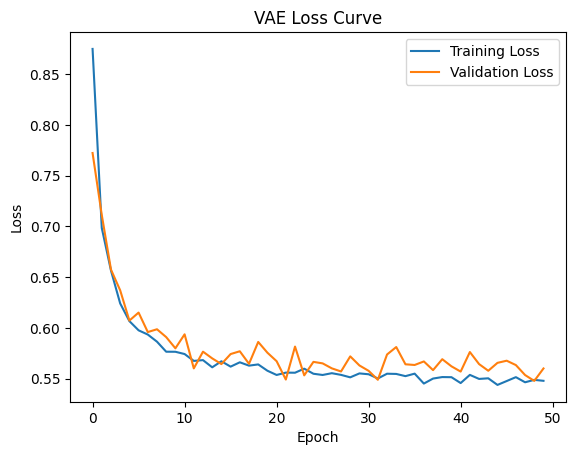

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

    Moderate       0.90      0.91      0.91       300
        Good       0.98      0.99      0.98       400
   Hazardous       0.80      0.75      0.77       100
        Poor       0.78      0.78      0.78       200

    accuracy                           0.90      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.90      0.90      0.90      1000

Models and mappings saved successfully in /kaggle/working/
Files saved: ['classifier.joblib', 'scaler.joblib', 'encoder_model.keras', 'label_mapping.json', '.virtual_documents']


In [33]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
import json
import os


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data for VAE training
X_train_full, X_val_full, y_train, y_val = train_test_split(
    X_scaled, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

# --- VAE ---
input_dim = X_train_full.shape[1]  # Should be 6 based on previous errors
latent_dim = 8

# Encoder
inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(64, activation='relu')(inputs)
h = layers.Dense(32, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

# Custom layer for KL loss
class KLLossLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(tf.reduce_mean(kl_loss))
        return inputs

# Apply KL loss layer
z_mean, z_log_var = KLLossLayer()([z_mean, z_log_var])

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = layers.Dense(32, activation='relu')(z)
decoder_h = layers.Dense(64, activation='relu')(decoder_h)
outputs = layers.Dense(input_dim, activation='linear')(decoder_h)

# Custom VAE model
class VAE(Model):
    def __init__(self, encoder_input, decoder_output, **kwargs):
        super().__init__(**kwargs)
        self.encoder_input = encoder_input
        self.decoder_output = decoder_output
        self.model = Model(encoder_input, decoder_output)

    def call(self, inputs):
        reconstruction = self.model(inputs)
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(inputs, reconstruction))
        self.add_loss(reconstruction_loss)
        return reconstruction

vae = VAE(inputs, outputs)
vae.compile(optimizer='adam')

# Train VAE
history = vae.fit(
    X_train_full, X_train_full,
    epochs=30, batch_size=32,
    validation_split=0.1, verbose=1
)

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("VAE Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Encoder for feature extraction
encoder = Model(inputs, z_mean)
X_latent = encoder.predict(X_scaled)

# --- Classification ---
X_train_latent, X_val_latent, y_train_latent, y_val_latent = train_test_split(
    X_latent, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42
)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_latent, y_train_latent)
y_pred = clf.predict(X_val_latent)

# Classification report
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
target_names = [inverse_label_mapping[i] for i in range(len(label_mapping))]
print("\nClassification Report:")
print(classification_report(y_val_latent, y_pred, target_names=target_names))

# --- Save Models for Inference ---
# Save to /kaggle/working/ directory
output_dir = '/kaggle/working/'

# Save the encoder model
encoder.save(os.path.join(output_dir, 'encoder_model.keras'))

# Save the RandomForestClassifier
joblib.dump(clf, os.path.join(output_dir, 'classifier.joblib'))

# Save the StandardScaler
joblib.dump(scaler, os.path.join(output_dir, 'scaler.joblib'))

# Save the label mapping
with open(os.path.join(output_dir, 'label_mapping.json'), 'w') as f:
    json.dump(label_mapping, f)

print("Models and mappings saved successfully in /kaggle/working/")
print("Files saved:", os.listdir(output_dir))

In [5]:
# Cài thư viện nếu chạy trên Kaggle hoặc local lần đầu
!pip install influxdb-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.2/746.2 kB 13.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 13.3 MB/s eta 0:00:00


In [6]:
from influxdb_client import InfluxDBClient
import pandas as pd

token = "rNKmS3Z7-_pqMbloCDVLeWJBaQq5AnflUidBT17ahV5kKePZbstxNxjLlr6kxegIdv0-HP6PSUG0N5QQ5_d0iA=="
org = "f4ea8e890f77d114"
bucket = "ESP32"
url = "https://us-east-1-1.aws.cloud2.influxdata.com"

client = InfluxDBClient(url=url, token=token, org=org)
query_api = client.query_api()

query = f'''
from(bucket: "{bucket}")
  |> range(start: time(v: 2025-05-12T08:36:35.229944418Z))
  |> filter(fn: (r) => r._measurement == "environment_data")
  |> filter(fn: (r) => r._field != "co2_ppm")
'''

# Truy vấn
tables = query_api.query(query)

# Xử lý dữ liệu
records = []
for table in tables:
    for record in table.records:
        row = {
            "time": record.get_time(),
            "field": record.get_field(),
            "value": record.get_value(),
            "measurement": record.get_measurement(),
        }
        for tag in ["device", "location"]:
            if tag in record.values:
                row[tag] = record.values[tag]
        records.append(row)

# Đưa vào DataFrame và pivot lại
df = pd.DataFrame(records)
df = df.pivot_table(
    index=["time", "location"],
    columns="field",
    values="value"
).reset_index()
df

field,time,location,co_ppm,dust_density,humidity,temperature
0,2025-05-12 08:36:35.229944+00:00,SPKT,0.0,0.00,48.0,29.1
1,2025-05-12 08:37:37.290253+00:00,SPKT,0.0,0.08,45.0,29.3
2,2025-05-12 08:38:39.341286+00:00,SPKT,0.0,0.09,43.0,29.2
3,2025-05-12 08:39:41.402442+00:00,SPKT,0.0,0.09,42.0,29.1
4,2025-05-12 08:40:43.464576+00:00,SPKT,0.0,0.09,43.0,29.0
...,...,...,...,...,...,...
2331,2025-05-14 00:40:33.115713+00:00,SPKT,0.0,0.00,67.0,27.5
2332,2025-05-14 00:41:33.537593+00:00,SPKT,0.0,0.19,67.0,27.5
2333,2025-05-14 00:42:33.951588+00:00,SPKT,0.0,0.42,66.0,27.4
2334,2025-05-14 00:43:34.363900+00:00,SPKT,0.0,0.00,64.0,27.2


In [7]:
# Chuyển đổi và xử lý
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.tz_convert('Asia/Ho_Chi_Minh')
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute

# Giới hạn co_ppm <= 3.72
df['co_ppm'] = np.clip(df['co_ppm'], a_min=None, a_max=3.72)

# Chọn cột
df = df[['date', 'hour', 'minute', 'location', 'co_ppm', 'dust_density', 'humidity', 'temperature']].copy()

# Hiển thị kết quả
print(df)

field        date  hour  minute location  co_ppm  dust_density  humidity  \
0      2025-05-12    15      36     SPKT     0.0          0.00      48.0   
1      2025-05-12    15      37     SPKT     0.0          0.08      45.0   
2      2025-05-12    15      38     SPKT     0.0          0.09      43.0   
3      2025-05-12    15      39     SPKT     0.0          0.09      42.0   
4      2025-05-12    15      40     SPKT     0.0          0.09      43.0   
...           ...   ...     ...      ...     ...           ...       ...   
2331   2025-05-14     7      40     SPKT     0.0          0.00      67.0   
2332   2025-05-14     7      41     SPKT     0.0          0.19      67.0   
2333   2025-05-14     7      42     SPKT     0.0          0.42      66.0   
2334   2025-05-14     7      43     SPKT     0.0          0.00      64.0   
2335   2025-05-14     7      44     SPKT     0.0          0.00      65.0   

field  temperature  
0             29.1  
1             29.3  
2             29.2  
3  

count    2336.000000
mean        1.580234
std         0.473578
min         0.650000
25%         1.245465
50%         1.441815
75%         1.862735
max         3.720000
Name: co_ppm, dtype: float64
Tỷ lệ giá trị dưới 1.5 ppm: 56.59%


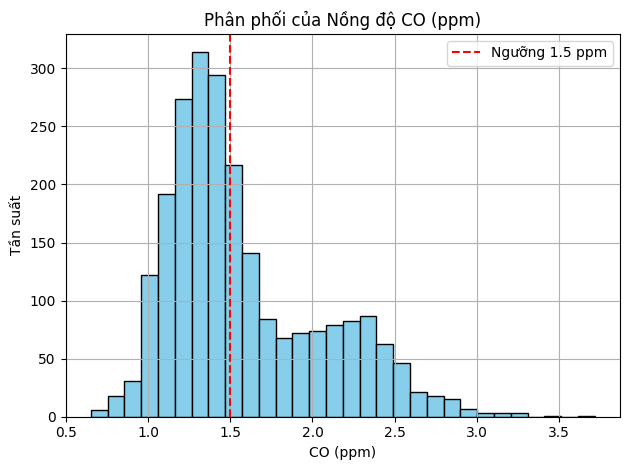

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Số hàng từ DataFrame
n_rows = len(df)

# Lấy dữ liệu nhiệt độ và độ ẩm
temperature = df['temperature'].values
humidity = df['humidity'].values

# Chuẩn hóa nhiệt độ và độ ẩm về [0, 1]
temp_min, temp_max = temperature.min(), temperature.max()
humid_min, humid_max = humidity.min(), humidity.max()
normalized_temp = (temperature - temp_min) / (temp_max - temp_min)
normalized_humid = (humidity - humid_min) / (humid_max - humid_min)

# Tạo dữ liệu CO giả với nhiễu mạnh
a, b, c = 1.5, 0.5, 0.3
noise = np.random.normal(0, 0.15, n_rows)  # Gaussian noise mạnh hơn
fake_data = a * (normalized_temp ** 2) + b * normalized_temp - c * normalized_humid + noise

# Thêm nhiễu ngẫu nhiên uniform
extra_noise = np.random.uniform(-0.1, 0.1, n_rows)
fake_data += extra_noise

# Chuẩn hóa và làm lệch phân phối sang trái (tập trung nhiều giá trị thấp)
fake_data = (fake_data - fake_data.min()) / (fake_data.max() - fake_data.min())
fake_data = np.power(fake_data, 1)

# Nếu chưa có cột 'co_ppm', tạo cột mới toàn 0
if 'co_ppm' not in df.columns:
    df['co_ppm'] = np.zeros(n_rows)

# Sao lưu dữ liệu gốc (nếu cần)
df['co_ppm_original'] = df['co_ppm']
original_co = df['co_ppm'].values

# Chuẩn hóa dữ liệu gốc về [0, 1]
if np.all(original_co == 0):
    normalized_co = np.zeros_like(original_co)
else:
    normalized_co = (original_co - original_co.min()) / (original_co.max() - original_co.min())
combined_data = normalized_co * 0.3 + fake_data * 0.7

# Scale về khoảng [0.65, 3.72] ppm
min_val, max_val = 0.65, 3.72
scaled_data = (combined_data - combined_data.min()) / (combined_data.max() - combined_data.min())
scaled_data = min_val + (max_val - min_val) * scaled_data
scaled_data = np.clip(scaled_data, min_val, max_val)

# Cập nhật lại vào DataFrame
df['co_ppm'] = scaled_data

# ======================
# Thống kê và trực quan
# ======================

# Mô tả thống kê
print(df['co_ppm'].describe())

# Tỷ lệ giá trị dưới 1.5 ppm
below_1_5 = (df['co_ppm'] < 1.5).mean() * 100
print(f"Tỷ lệ giá trị dưới 1.5 ppm: {below_1_5:.2f}%")

# Vẽ biểu đồ histogram
df['co_ppm'].hist(bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=1.5, color='red', linestyle='--', label='Ngưỡng 1.5 ppm')
plt.title('Phân phối của Nồng độ CO (ppm)')
plt.xlabel('CO (ppm)')
plt.ylabel('Tần suất')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
df['dust_density'] = df['dust_density'].replace(0, np.nan)

# Nội suy tuyến tính cho các NaN
df['dust_density'] = df['dust_density'].interpolate(method='linear')

# Nếu còn NaN ở đầu hoặc cuối, dùng ffill và bfill để lấp đầy
df['dust_density'] = df['dust_density'].ffill()
df['dust_density'] = df['dust_density'].bfill()
df

field,date,hour,minute,location,co_ppm,dust_density,humidity,temperature,co_ppm_original
0,2025-05-12,15,36,SPKT,2.133482,0.08,48.0,29.1,0.0
1,2025-05-12,15,37,SPKT,1.947746,0.08,45.0,29.3,0.0
2,2025-05-12,15,38,SPKT,2.411854,0.09,43.0,29.2,0.0
3,2025-05-12,15,39,SPKT,2.041975,0.09,42.0,29.1,0.0
4,2025-05-12,15,40,SPKT,1.893137,0.09,43.0,29.0,0.0
...,...,...,...,...,...,...,...,...,...
2331,2025-05-14,7,40,SPKT,1.497874,0.25,67.0,27.5,0.0
2332,2025-05-14,7,41,SPKT,1.480864,0.19,67.0,27.5,0.0
2333,2025-05-14,7,42,SPKT,1.327342,0.42,66.0,27.4,0.0
2334,2025-05-14,7,43,SPKT,1.184413,0.42,64.0,27.2,0.0


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Giả sử df là DataFrame chứa các dữ liệu cần thiết
# Dữ liệu đã có cột 'co_ppm' từ bước trước (hoặc bạn có thể tạo lại nếu cần)
# Tôi sẽ sử dụng len(df) để lấy số hàng
n_rows = len(df)

# Lấy dữ liệu cho các biến
data_temperature = df['temperature'].values.reshape(-1, 1)
data_humidity = df['humidity'].values.reshape(-1, 1)
data_dust_density = df['dust_density'].values.reshape(-1, 1)
data_co_ppm = df['co_ppm'].values.reshape(-1, 1)  # Thêm cột co_ppm

# Chuẩn hóa dữ liệu về khoảng [0, 1]
scaler_temperature = MinMaxScaler(feature_range=(0, 1))
scaler_humidity = MinMaxScaler(feature_range=(0, 1))
scaler_dust_density = MinMaxScaler(feature_range=(0, 1))
scaler_co_ppm = MinMaxScaler(feature_range=(0, 1))  # Chuẩn hóa co_ppm

scaled_temperature = scaler_temperature.fit_transform(data_temperature)
scaled_humidity = scaler_humidity.fit_transform(data_humidity)
scaled_dust_density = scaler_dust_density.fit_transform(data_dust_density)
scaled_co_ppm = scaler_co_ppm.fit_transform(data_co_ppm)  # Chuẩn hóa co_ppm

# --- BƯỚC 2: Tạo chuỗi dữ liệu cho mỗi biến ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 300  # Sử dụng 300 giá trị trước đó để dự đoán giá trị tiếp theo

# Tạo chuỗi cho mỗi biến
X_temp, y_temp = create_sequences(scaled_temperature, seq_length)
X_hum, y_hum = create_sequences(scaled_humidity, seq_length)
X_dust_density, y_dust_density = create_sequences(scaled_dust_density, seq_length)
X_co_ppm, y_co_ppm = create_sequences(scaled_co_ppm, seq_length)  # Chuỗi cho co_ppm

# Reshape cho phù hợp với LSTM input
X_temp = np.reshape(X_temp, (X_temp.shape[0], X_temp.shape[1], 1))
X_hum = np.reshape(X_hum, (X_hum.shape[0], X_hum.shape[1], 1))
X_dust_density = np.reshape(X_dust_density, (X_dust_density.shape[0], X_dust_density.shape[1], 1))
X_co_ppm = np.reshape(X_co_ppm, (X_co_ppm.shape[0], X_co_ppm.shape[1], 1))  # Reshape cho co_ppm

# --- BƯỚC 3: Chia tập Huấn luyện và Kiểm tra ---
X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
X_train_hum, X_val_hum, y_train_hum, y_val_hum = train_test_split(X_hum, y_hum, test_size=0.2, random_state=42)
X_train_dust_density, X_val_dust_density, y_train_dust_density, y_val_dust_density = train_test_split(X_dust_density, y_dust_density, test_size=0.2, random_state=42)
X_train_co_ppm, X_val_co_ppm, y_train_co_ppm, y_val_co_ppm = train_test_split(X_co_ppm, y_co_ppm, test_size=0.2, random_state=42)  # Chia tập cho co_ppm

# --- BƯỚC 4: Xây dựng Mô hình LSTM ---
def build_model():
    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))  # Định nghĩa input layer
    model.add(LSTM(units=100, return_sequences=True))
    model.add(LSTM(units=100))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# --- BƯỚC 5: Huấn luyện mô hình cho từng biến ---
# Huấn luyện cho temperature
model_temp = build_model()
history_temp = model_temp.fit(
    X_train_temp, y_train_temp,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_temp, y_val_temp),
    verbose=1
)
predictions_temp = model_temp.predict(X_val_temp)

# Huấn luyện cho humidity
model_hum = build_model()
history_hum = model_hum.fit(
    X_train_hum, y_train_hum,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_hum, y_val_hum),
    verbose=1
)
predictions_hum = model_hum.predict(X_val_hum)

# Huấn luyện cho dust_density
model_dust = build_model()
history_dust_density = model_dust.fit(
    X_train_dust_density, y_train_dust_density,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_dust_density, y_val_dust_density),
    verbose=1
)
predictions_dust_density = model_dust.predict(X_val_dust_density)

# Huấn luyện cho co_ppm
model_co_ppm = build_model()
history_co_ppm = model_co_ppm.fit(
    X_train_co_ppm, y_train_co_ppm,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_co_ppm, y_val_co_ppm),
    verbose=1
)
predictions_co_ppm = model_co_ppm.predict(X_val_co_ppm)  # Dự đoán cho co_ppm

# --- BƯỚC 6: Inverse Transform kết quả về thang đo gốc ---
predictions_temp = scaler_temperature.inverse_transform(predictions_temp)
y_val_temp_actual = scaler_temperature.inverse_transform(y_val_temp.reshape(-1, 1))

predictions_hum = scaler_humidity.inverse_transform(predictions_hum)
y_val_hum_actual = scaler_humidity.inverse_transform(y_val_hum.reshape(-1, 1))

predictions_dust_density = scaler_dust_density.inverse_transform(predictions_dust_density)
y_val_dust_density_actual = scaler_dust_density.inverse_transform(y_val_dust_density.reshape(-1, 1))

predictions_co_ppm = scaler_co_ppm.inverse_transform(predictions_co_ppm)  # Inverse transform cho co_ppm
y_val_co_ppm_actual = scaler_co_ppm.inverse_transform(y_val_co_ppm.reshape(-1, 1))


2025-05-14 00:45:16.538300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747183516.741404      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747183516.801764      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1747183527.797931      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/20


I0000 00:00:1747183531.941384     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0519 - val_loss: 0.0029
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0022 - val_loss: 9.4612e-04
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 9.5726e-04 - val_loss: 8.9029e-04
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 9.1260e-04 - val_loss: 8.5660e-04
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 8.3490e-04 - val_loss: 9.2812e-04
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 8.9479e-04 - val_loss: 7.9796e-04
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.4791e-04 - val_loss: 8.3062e-04
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 8.0555e-04 - val_loss: 7.2889e-04
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 7.6877e-04 - val_loss: 6.9937e-04
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 6.2909e-04 - val_loss: 6.8238e-04
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.1283e-04 - val_loss: 6.4702e-0

In [11]:
model_temp.save('model_temperature.h5')
print("Đã lưu mô hình temperature thành model_temperature.h5")

model_hum.save('model_humidity.h5')
print("Đã lưu mô hình humidity thành model_humidity.h5")

model_dust.save('model_dust_density.h5')
print("Đã lưu mô hình dust_density thành model_dust_density.h5")

model_co_ppm.save('model_co_ppm.h5')
print("Đã lưu mô hình co_ppm thành model_co_ppm.h5")

Đã lưu mô hình temperature thành model_temperature.h5
Đã lưu mô hình humidity thành model_humidity.h5
Đã lưu mô hình dust_density thành model_dust_density.h5
Đã lưu mô hình co_ppm thành model_co_ppm.h5


RMSE cho Temperature: 0.19
RMSE cho Humidity: 1.17
RMSE cho Dust Density: 0.52
RMSE cho CO (ppm): 0.19


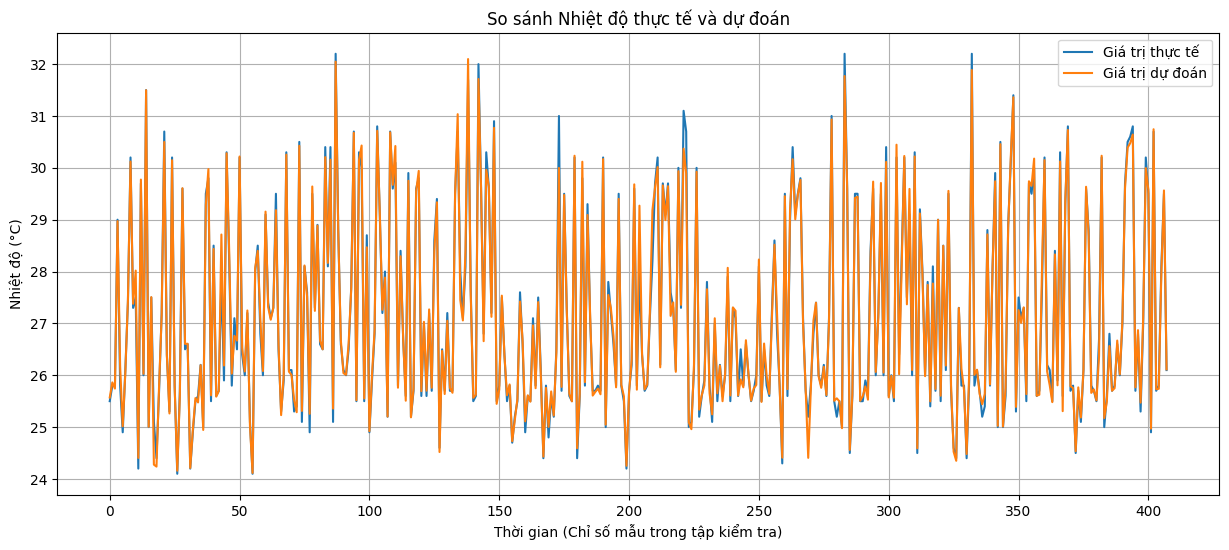

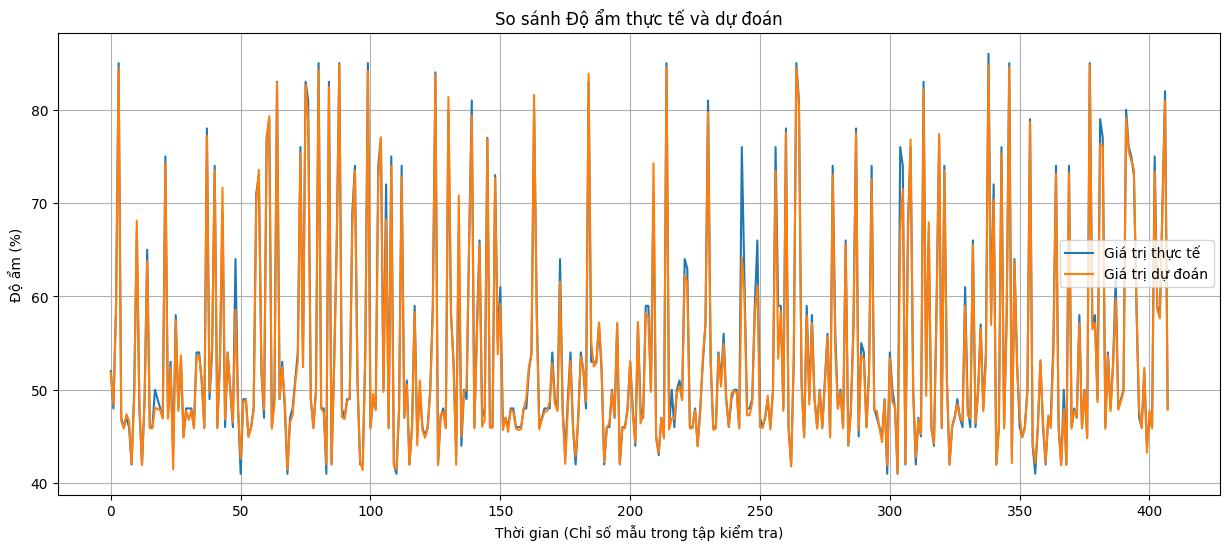

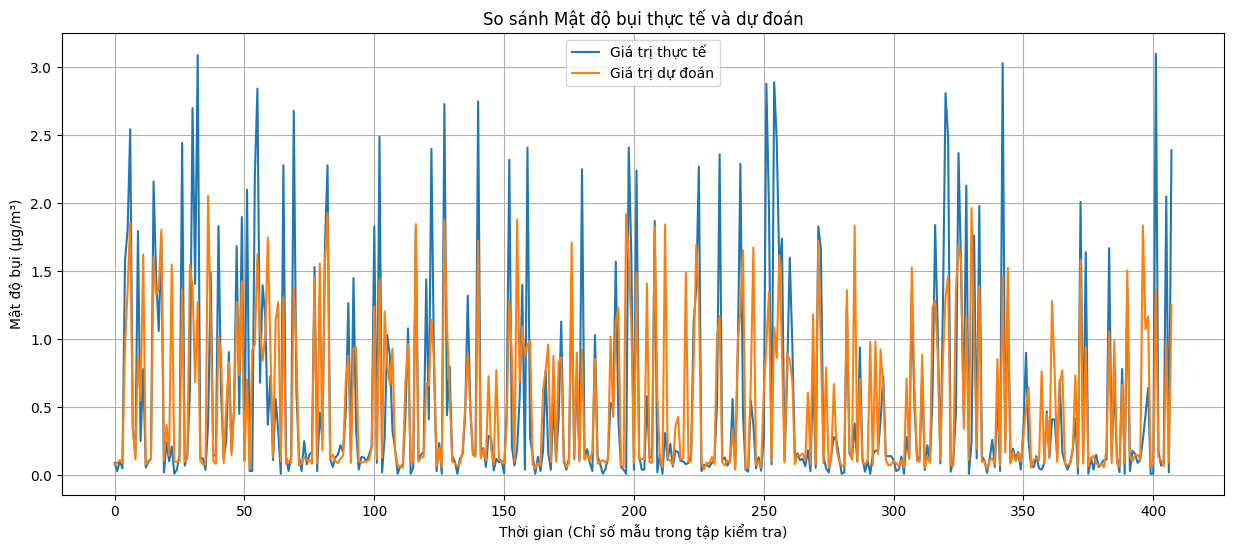

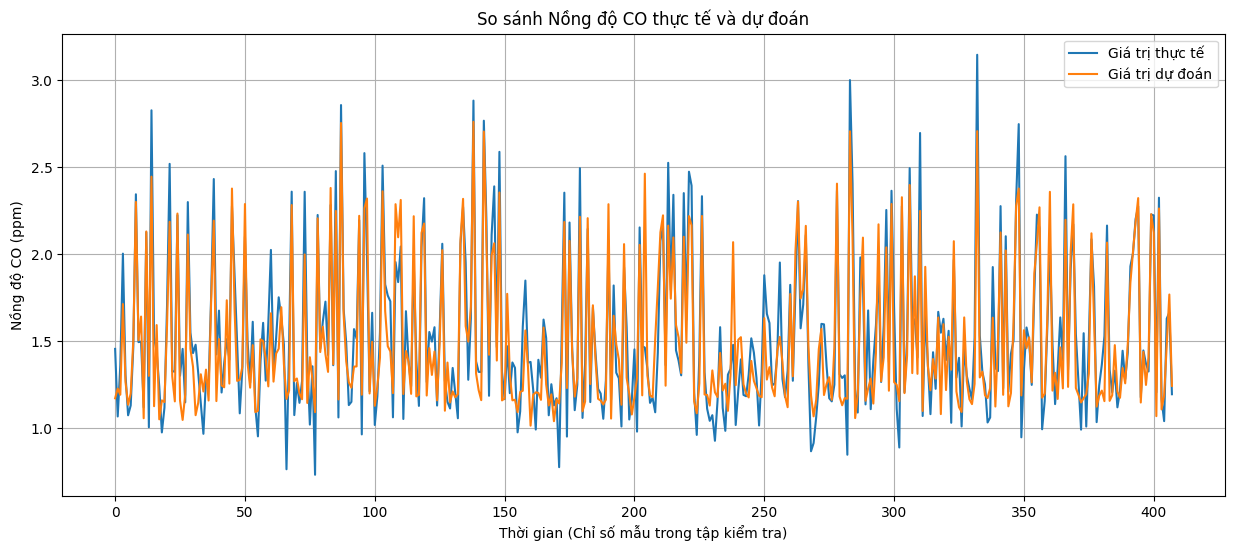

In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- BƯỚC 7: Đánh giá và vẽ biểu đồ cho từng biến ---

# Tính toán RMSE cho temperature
rmse_temp = math.sqrt(mean_squared_error(y_val_temp_actual, predictions_temp))
print(f"RMSE cho Temperature: {rmse_temp:.2f}")

# Tính toán RMSE cho humidity
rmse_hum = math.sqrt(mean_squared_error(y_val_hum_actual, predictions_hum))
print(f"RMSE cho Humidity: {rmse_hum:.2f}")

# Tính toán RMSE cho dust_density
rmse_dust_density = math.sqrt(mean_squared_error(y_val_dust_density_actual, predictions_dust_density))
print(f"RMSE cho Dust Density: {rmse_dust_density:.2f}")

# Tính toán RMSE cho co_ppm
rmse_co_ppm = math.sqrt(mean_squared_error(y_val_co_ppm_actual, predictions_co_ppm))
print(f"RMSE cho CO (ppm): {rmse_co_ppm:.2f}")

# Vẽ biểu đồ cho temperature
plt.figure(figsize=(15, 6))
plt.plot(y_val_temp_actual, label='Giá trị thực tế')
plt.plot(predictions_temp, label='Giá trị dự đoán')
plt.title('So sánh Nhiệt độ thực tế và dự đoán')
plt.xlabel('Thời gian (Chỉ số mẫu trong tập kiểm tra)')
plt.ylabel('Nhiệt độ (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ cho humidity
plt.figure(figsize=(15, 6))
plt.plot(y_val_hum_actual, label='Giá trị thực tế')
plt.plot(predictions_hum, label='Giá trị dự đoán')
plt.title('So sánh Độ ẩm thực tế và dự đoán')
plt.xlabel('Thời gian (Chỉ số mẫu trong tập kiểm tra)')
plt.ylabel('Độ ẩm (%)')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ cho dust_density
plt.figure(figsize=(15, 6))
plt.plot(y_val_dust_density_actual, label='Giá trị thực tế')
plt.plot(predictions_dust_density, label='Giá trị dự đoán')
plt.title('So sánh Mật độ bụi thực tế và dự đoán')
plt.xlabel('Thời gian (Chỉ số mẫu trong tập kiểm tra)')
plt.ylabel('Mật độ bụi (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ cho co_ppm
plt.figure(figsize=(15, 6))
plt.plot(y_val_co_ppm_actual, label='Giá trị thực tế')
plt.plot(predictions_co_ppm, label='Giá trị dự đoán')
plt.title('So sánh Nồng độ CO thực tế và dự đoán')
plt.xlabel('Thời gian (Chỉ số mẫu trong tập kiểm tra)')
plt.ylabel('Nồng độ CO (ppm)')
plt.legend()
plt.grid(True)
plt.show()